In [1]:
!pip install qiskit

In [2]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister, Aer, execute
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython.display import display, Math, Latex
import math as m

%matplotlib inline

# QKD with BB84 protocol

* Quantum Key Distribution protocol proposed by Bennett and Brassard in 1984
* Context: Alice and Bob are trying to share a message. Eve is trying to illegally intercept this message. Alice and Bob must protect their message from the eavesdropper (Eve).

Solution: 

A one-time key is an impenetrable encryption method that Alice can use to send Bob a secret message. Simply said, a one-time key is a key that is only ever used once.

Why does this work:

Alice and Bob would have put that key away and moved on to another by the time Eve gets her hands on the message. Therefore, Eve is unable to decrypt the message unless she has access to the key or can correctly predict the key.

Key Distribution: 

Getting the key to both communication parties while reducing the possibility of Eve learning about it is the process of key distribution. This process when implemented using the advantage of quantum systems gives rise to QKD. So, essentially, QKD consists of 2 broad steps. In the 1st part, we use some quantum principles to try to eliminate the presence of an eavesdropper and generate a secure key. In the 2nd part, we use the generated key to decrypt the message, also known as 'Classical post-processing'.

## The BB84 Protocol

In the straightforward "prepare and measure" BB84 protocol, Alice prepares a series of qubits, sends the qubits to Bob, and Bob measures the qubits. Those for which the two measurement bases do not agree are discarded. The remainder of the bit string is used as the raw key, and a portion is utilised to check for an eavesdropper (Eve).

The protocol works something like this:

- Alice generates a random bit string.
- Alice encodes the bits in qubit states by randomly choosing between two bases, say, the perpendicular (z) and diagonal (x) bases.

She follows a convention that she established before hand, perhaps something like this:

|   | 0  | 1  |
|---|---|---|
|  z basis | $\uparrow$  | $\rightarrow$  |  
|  x basis | $\nwarrow$  | $\nearrow$  |   

Suppose Alice generates the bit string 100100. She then prepares a set of 6 qubits in the following manner:


|  Alice's Random Bits |  1 | 0  | 0  | 1  | 0  | 0  |
|---|---|---|---|---|---|---|
| Alice's Random Basis Choice |  X | Z  |  Z |  X | Z  | X  |
| What Alice Sends Bob  |  $\nearrow$ |  $\uparrow$ | $\uparrow$  | $\nearrow$  | $\uparrow$  | $\nwarrow$  |


- Alice sends the qubit sequence to Bob over a quantum channel.
- Bob randomly chooses his measurement bases.
- Alice and Bob publicize their measurement bases choices through an open communication channel, and retain those qubits for which the bases match.


|  Alice's Random Bits |  1 | 0  | 0  | 1  | 0  | 0  |
|---|---|---|---|---|---|---|
| Alice's Random Basis Choice |  X | Z  |  Z |  X | Z  | X  |
|  What Alice Sends Bob |  $\nearrow$ |  $\uparrow$ | $\uparrow$  | $\nearrow$  | $\uparrow$  | $\nwarrow$  |
| Bob's Random Basis Choice  | X  | Z  |  X | X  | Z  | Z  |
| Shared Information  | 1  | 0  | -  | 1  | 0  |  -  |

- A subset of the sequence is used to check for the presence of an eavesdropper. So, if the first two bits are selected, then Alice and Bob would check if they both have the result 10. If their answers don't match, then Eve was probably snooping around. If their answers match, they can use the rest of the sequence, the second 10, as a raw key.

This is the end of the BB84 protocol, but Alice and Bob are not quite yet done with their work. They still have the classical component of QKD to work through! The key that they have at the end of the quantum part is a raw key. Usually the raw key is just that: raw with errors. A final key is distilled from the raw key through post-processing that is completely classical, because they are now working with bit strings. Post-processing includes  privacy amplification and information reconcilliation.

In [3]:
class Alice:
    def prepareState(self, n):        
        nQubits = int((4 )*n) # number of physical qubits        
        a = np.random.randint(2, size=(nQubits,))      # random data bits
        b = np.random.randint(2, size=(nQubits,))      # random bases bits
        return (a, b)
    
class Bob:
    def generateRandomBasis(self, n):
        nQubits = int((4)*n) # number of physical qubitsb
        b = np.random.randint(2, size=(nQubits,))
        return b
        
class Eve:
    def generateRandomBasis(self, n):
        nQubits = int((4 )*n) # number of physical qubits
        b = np.random.randint(2, size=(nQubits,))
        return b

We construct two circuits: BB84 which has no eavesdroppers and BB84-Eve where Eve eavesdrops by performing measurements before the qubits reach Bob.

Note that we choose $n \leq 8$ (key length) for our experiment. We choose a small key length due to our computational constraints. In practice, one would use a much larger key size.ize.

In [4]:
def BB84Program(key_length):
    
    # key length
    n = key_length
    # number of physical qubits
    nQubits = int((4)*n)
    
    # Creating registers
    # qubits for querying the oracle and finding the hidden integer
    qr_1 = QuantumRegister(nQubits,"qr_1")
    # for recording the measurement on qr
    cr_1 = ClassicalRegister(nQubits,"cr_1")
    
    # qubits for querying the oracle and finding the hidden integer
    qr_2 = QuantumRegister(nQubits,"qr_2")
    # for recording the measurement on qr
    cr_2 = ClassicalRegister(nQubits,"cr_2")
    
    bbCircuit = QuantumCircuit( qr_1, cr_1)
    bb_eve_Circuit = QuantumCircuit( qr_2, cr_2)
    
    # Initialize Alice and Bob ... and Eve! 
    alice = Alice()
    bob = Bob()
    eve = Eve()
    
    # Have Alice generate secrets a, b with chosen n and delta
    (a, b) = alice.prepareState(n)
    
    # Apply Hadamard gates before querying the oracle
    for i in range(nQubits):
        if a[i] == 1:
            # X gates will send |0> -> |1> 
            bbCircuit.x(qr_1[i])
            bb_eve_Circuit.x(qr_2[i])
    
    for i in range(nQubits):
        if b[i] == 1:
            # encode in X basis
            bbCircuit.h(qr_1[i])
            bb_eve_Circuit.h(qr_2[i])
    
    # Bob generates his random basis string, b'
    b_prime = bob.generateRandomBasis(n)
    
    # Eve also takes a stab at guessing the basis
    b_eve = eve.generateRandomBasis(n)
    
    # Eve makes some measurements !
    for i in range(nQubits):
        if b_eve[i] == 1:
            # measure in X basis (otherwise Eve measures in Z)
            bb_eve_Circuit.h(qr_2[i])
        else:
            bb_eve_Circuit.x(qr_2[i])
    
    # Bob measures the qubits based off of b'
    
    for i in range(nQubits):
        if b_prime[i] == 1:
            # measure in X basis (as opposed to Z)
            bbCircuit.h(qr_1[i])
            bb_eve_Circuit.h(qr_2[i])
        
    bbCircuit.measure(qr_1, cr_1)
    bb_eve_Circuit.measure(qr_2, cr_2)
        
    return (bbCircuit, bb_eve_Circuit, a, b, b_prime)

Once Bob performs his measurements, using this circuit, we can perform steps for determining the key. We define a method to do these steps.

In [5]:
def determineKey(a, bob_meas, b, b_prime):
    # Now, it is safe for Alice to announce b to Bob. They can then determine in which places their b and b' agree.
    # Let's call the indices where b_i = b'_i, array x
    x = [b_i == b_prime_i for (b_i, b_prime_i) in zip(b, b_prime)]
    
    # The size of x should be 1/2 nQubits, in expectation
    if len(x) < 2*n :
        print("Aborting protocol. Less than 2n bits match between b and b'")
        return False
    else:
        alice_bits = []               # Alice's original secret key, a, subsetted where b and b' agree
        bob_bits = []                # Bob's measurement in his random basis b', subsetted where b and b' agree
        for y in x:
            alice_bits.append(a[y])
            bob_bits.append(bob_meas[y])
    
        # Now, we can use half of these bits as "check bits" to see if there was any interference (announcing publicly)
        # Let's just take the first n bits as check bits, WLOG
        
        check_alice = alice_bits[:n]
        key_alice = alice_bits[-n:]
        check_bob = bob_bits[:n]
        key_bob = bob_bits[-n:]

        error = 0
        # Now, they publicly determine the error in their check bits
        mismatch = [k_a != k_b for (k_a, k_b) in zip(key_alice, key_bob)]
        if len(mismatch)>0:
            error = (np.sum(mismatch)) / n
        
        # Let's choose epsilon = 0.05 as our error threshold
        epsilon = 0.05
        if error > epsilon:
            return False
        else:
            return True

## Experiment with Simulators

We can run the above circuits in the simulator. This will gives us the results of Bob's measurements using his random basis, in both cases (with or without eavesdropping). If there is no noise or interference by Eve, then Bob's measurements should match up precisely with Alice's key $a$, at the qubits where Alice and Bob both chose the same basis. Hence, we can take this subset of Bob's measurement to use as check bits and key bits. 

We also show the probabilities of various outcomes Bob could see, which are computed by simulating the above circuit using the same $a$, $b$, and $b'$, $2^{10}$ times noting the number of occurences of each outcome.

In [6]:
def testCircuits(shots, key_length):
    # use local qasm simulator
    backend = Aer.get_backend("aer_simulator")
    q,q_eve, a, b, b_prime = BB84Program(key_length)
    
    results = execute(q, backend=backend, timeout=600, shots=shots).result()
    answer = results.get_counts(q)
    
    results_eve = execute(q_eve, backend=backend, timeout=600, shots=shots).result()
    answer_eve = results_eve.get_counts(q_eve)
    
    return (answer, answer_eve, a, b, b_prime)

Of course, Bob will not see a probability distribution, but rather one of these particular outcomes. Hence, we'll take one of these outcomes at random.

In [7]:
def getMeasurement(answer, answer_eve):
    bob_meas = list(random.choice(list(answer.keys())))
    bob_meas = list(map(int, bob_meas))
    bob_meas = np.array(bob_meas)
    bob_meas = bob_meas[::-1]
    
    bob_meas_eve = list(random.choice(list(answer_eve.keys())))
    bob_meas_eve = list(map(int, bob_meas_eve))
    bob_meas_eve = np.array(bob_meas_eve)
    bob_meas_eve = bob_meas_eve[::-1]
    
    return (bob_meas, bob_meas_eve)

In [8]:
def plot_eve_undetected(probs):
    
    objects = ('2','4','7')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, probs, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    
    plt.xlabel("Key Length")
    plt.ylabel('Probability')
    plt.title('Probability of Successful BB84')
    
    plt.show()

In [9]:
probs = []

for n in [2,4,7]:
    succ = 0
    succ_eve = 0
    for i in range(2**8):
        # Simulate one measurement with key length n = 4
        (answer, answer_eve, a, b, b_prime) = testCircuits(1, n)
        bob_meas, bob_meas_eve = getMeasurement(answer, answer_eve)
        res = determineKey(a, bob_meas, b, b_prime)
        # successful
        if res: 
            succ += 1
        res = determineKey(a, bob_meas_eve, b, b_prime)
        # successful
        if res: 
            succ_eve += 1
    p_eve = (succ_eve) / (2**8)
    probs.append(p_eve)

C:\Users\bansa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\bansa\AppData\Local\Temp\ipykernel_56052\1428759319.py:33: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if error > epsilon:


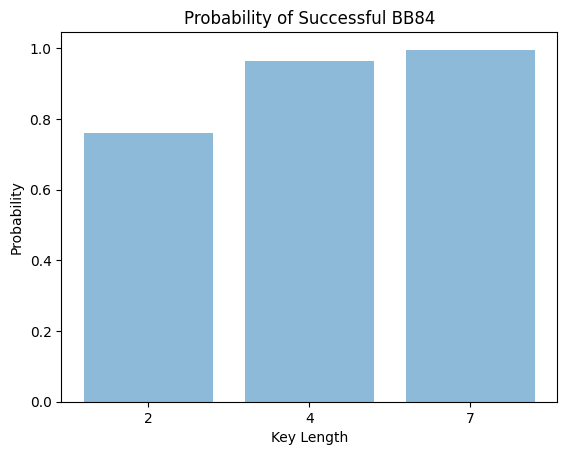

In [10]:
plot_eve_undetected(probs)